# CyTOF Label Transfer: Advanced Workflow
## Feature Evaluation, Selection, Custom Hyperparameters, and Prediction

This notebook demonstrates the complete workflow for CyTOF label transfer with the new features:
1. **Feature Evaluation**: Compute and visualize feature importance before training
2. **Feature Selection**: Select features by group or importance threshold
3. **Custom Hyperparameters**: Use custom XGBoost hyperparameter distributions
4. **Model Training**: Train with cross-validated hyperparameter search
5. **Evaluation**: Generate QC plots and metrics
6. **Prediction**: Apply trained model to target timepoint

**Prerequisites**:
- conda environment from `environment.yml`
- `.h5ad` file with timepoints and trusted labels for timepoints 1–4

## 1. Import Required Libraries

In [1]:
# Clear module cache to ensure fresh imports
import sys
if 'cytof_label_transfer' in sys.modules:
    del sys.modules['cytof_label_transfer']
if 'cytof_label_transfer.data_utils' in sys.modules:
    del sys.modules['cytof_label_transfer.data_utils']
if 'cytof_label_transfer.model' in sys.modules:
    del sys.modules['cytof_label_transfer.model']
if 'cytof_label_transfer.feature_selection' in sys.modules:
    del sys.modules['cytof_label_transfer.feature_selection']
if 'cytof_label_transfer.qc' in sys.modules:
    del sys.modules['cytof_label_transfer.qc']

# Core imports
import os
import json
from pathlib import Path

# Data handling
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

import scvi

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# CyTOF Label Transfer
from cytof_label_transfer import (
    load_anndata,
    split_timepoints,
    extract_xy,
    compute_feature_importance,
    create_feature_groups,
    plot_feature_importance,
    select_features_by_groups,
    select_features_by_importance,
    select_features_interactive_report,
    train_classifier,
    load_hyperparameters_from_json,
    predict_timepoint,
)
from cytof_label_transfer.data_utils import extract_x_target
from cytof_label_transfer.qc import evaluate_and_plot_cv
from cytof_label_transfer.model import TrainedModelBundle

# Plotting configuration
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print('✓ All libraries imported successfully')
print(f'Working directory: {os.getcwd()}')

/home/md-adnan-karim/miniconda3/envs/scrna_spatial/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/md-adnan-karim/miniconda3/envs/scrna_spatial/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully
Working directory: /home/md-adnan-karim/Documents/git_repo/cytofLabelTransfer/cytofPredictionModel


## 2. Load and Prepare Data

In [18]:
# Configure paths and parameters
INPUT_H5AD = '/home/md-adnan-karim/Documents/git_repo/cytofLabelTransfer/results_260123/230126_data_with_predictions.h5ad'  # UPDATE THIS PATH
TIMEPOINT_COL = 'ROI_round_id'             # Column name for timepoints
LABEL_COL = 'Gate_immune'                  # Column name for cell type labels
OBSM_KEY = 'X_scVI_1_2'           # Optional: latent space key (set to None if not using)
LAYER = None                            # Optional: layer name (None = use .X)

# Output directories
OUTPUT_DIR = Path('results')
FEATURE_EVAL_DIR = OUTPUT_DIR / 'feature_evaluation'
MODEL_DIR = OUTPUT_DIR / 'trained_model'

# Training parameters
TRAIN_TIMEPOINTS = [1.0, 2.0]  # Trusted timepoints
TARGET_TIMEPOINT = [3.0,4.0,5.0]             # Target timepoint for prediction

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FEATURE_EVAL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f'✓ Configuration set')
print(f'  Input file: {INPUT_H5AD}')
print(f'  Output directory: {OUTPUT_DIR}')
print(f'  Training timepoints: {TRAIN_TIMEPOINTS}')
print(f'  Target timepoint: {TARGET_TIMEPOINT}')

✓ Configuration set
  Input file: /home/md-adnan-karim/Documents/git_repo/cytofLabelTransfer/results_260123/230126_data_with_predictions.h5ad
  Output directory: results
  Training timepoints: [1.0, 2.0]
  Target timepoint: [3.0, 4.0, 5.0]


In [3]:
# Load AnnData object
print(f'Loading data from {INPUT_H5AD}...')
adata = load_anndata(INPUT_H5AD)

print(f'\n✓ Data loaded successfully')
print(f'  Shape: {adata.n_obs} cells × {adata.n_vars} genes')
print(f'  Timepoints: {sorted(adata.obs[TIMEPOINT_COL].unique())}')
print(f'  Cell types: {adata.obs[LABEL_COL].nunique()} types')
if OBSM_KEY:
    print(f'  Latent space ({OBSM_KEY}): {adata.obsm[OBSM_KEY].shape[1]} dimensions')

Loading data from /home/md-adnan-karim/Documents/git_repo/cytofLabelTransfer/results_260123/230126_data_with_predictions.h5ad...

✓ Data loaded successfully
  Shape: 1037871 cells × 52 genes
  Timepoints: ['Healthy', 'T0', 'T1', 'T2']
  Cell types: 7 types
  Latent space (X_scVI_200_epoch): 10 dimensions


In [10]:
adata.obs["group"].value_counts()

group
CAR        595887
Healthy    267184
RTX        174800
Name: count, dtype: int64

In [4]:
adata = adata[adata.obs["group"] != "RTX"].copy()

In [5]:
adata.obs["Gate_immune"].value_counts()

Gate_immune
T_cell         288265
Stroma         257556
Myeloid        191490
B_cell          84145
Endothelial     32513
FDCs             8586
Tfh               516
Name: count, dtype: int64

In [6]:
##recompute scvi for selected features
# Your custom list of features
my_selected_genes = ["CD45", "CD19", "CD20", "CD138", 
                     "CD3", "CD4","CD8a", "CD14", "CD15", "CD11b", "CD11c",
                     "CD68", "CD21", "CD23", "CD31", "PD-1", "Bcl6"] 

# Check if genes exist in the dataset to avoid KeyErrors
valid_genes = [g for g in my_selected_genes if g in adata.var_names]

# Subset the AnnData object to ONLY these features
adata_subset = adata[:, valid_genes].copy()

In [7]:
scvi.model.SCVI.setup_anndata(
    adata_subset,
    layer="counts",
    categorical_covariate_keys=["sample_id"],
)
model = scvi.model.SCVI(adata_subset, n_layers=2, n_latent=30, gene_likelihood="nb")



/home/md-adnan-karim/miniconda3/envs/scrna_spatial/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [8]:
model.train(max_epochs=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA RTX 2000 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/md-adnan-karim/miniconda3/envs/scrna_spatial/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 50/50: 100%|██████████| 50/50 [35:14<00:00, 42.36s/it, v_num=1, train_loss=11.2]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [35:14<00:00, 42.29s/it, v_num=1, train_loss=11.2]


In [9]:
latent = model.get_latent_representation()
adata_subset.obsm["X_scVI_1_2"] = latent
sc.pp.neighbors(adata_subset, use_rep="X_scVI_1_2", n_neighbors=15)


In [10]:
sc.tl.umap(adata_subset)

In [22]:
adata_subset.write_h5ad('/home/md-adnan-karim/Documents/git_repo/cytofLabelTransfer/cytofPredictionModel/datasets/260129_data_with_selected_features_scvi.h5ad')

In [14]:
adata_subset

AnnData object with n_obs × n_vars = 863071 × 17
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'sample_id', 'ObjectNumber', 'area', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'width_px', 'height_px', 'ROI', 'ROI_round_id', 'ROI_numb', 'patient_id', 'patient_id_numb', 'timepoint', 'timepoint_numb', 'group', 'group_numb', 'time_group', 'time_group_numb', 'disease', 'disease_numb', 'size.filter', 'names', 'UMAP_1_before', 'UMAP_2_before', 'UMAP_1_after', 'UMAP_2_after', 'Clust_all', 'Gate_immune', 'aggregatedNeighbors.CD23._Bcl6._B_cell', 'aggregatedNeighbors.CD4._activated', 'aggregatedNeighbors.CD4._naive', 'aggregatedNeighbors.CD8._activated', 'aggregatedNeighbors.CD8._naive', 'aggregatedNeighbors.cDC', 'aggregatedNeighbors.Discard_cell', 'aggregatedNeighbors.Endothelial', 'aggregatedNeighbors.FDCs', 'aggregatedNeighbors.GC_B_cell', 'aggregatedNeighbors.HLADR._B_cell', 'aggregatedNeighbors.Macro_CD11c._HLADR.', 'aggregatedNeighbors.Macro_CD11c._HLA

In [17]:
# Split data into training and target
print(f'Splitting data...')
adata_train = adata_subset[adata_subset.obs["ROI_round_id"].isin(TRAIN_TIMEPOINTS)].copy()
adata_target = adata_subset[adata_subset.obs["ROI_round_id"].isin(TARGET_TIMEPOINT)].copy()

print(f'\n✓ Data split successfully')
print(f'  Training set: {adata_train.n_obs} cells from timepoints {TRAIN_TIMEPOINTS}')
print(f'  Target set: {adata_target.n_obs} cells from timepoint {TARGET_TIMEPOINT}')

# Display cell type distribution in training set
print(f'\nCell type distribution in training set:')
print(adata_train.obs[LABEL_COL].value_counts())

Splitting data...

✓ Data split successfully
  Training set: 268700 cells from timepoints [1.0, 2.0]
  Target set: 594371 cells from timepoint [3.0, 4.0, 5.0]

Cell type distribution in training set:
Gate_immune
T_cell         88284
Myeloid        68657
Stroma         65319
B_cell         34972
Endothelial     9670
FDCs            1597
Tfh              201
Name: count, dtype: int64


In [16]:
adata_target

AnnData object with n_obs × n_vars = 0 × 17
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'sample_id', 'ObjectNumber', 'area', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'width_px', 'height_px', 'ROI', 'ROI_round_id', 'ROI_numb', 'patient_id', 'patient_id_numb', 'timepoint', 'timepoint_numb', 'group', 'group_numb', 'time_group', 'time_group_numb', 'disease', 'disease_numb', 'size.filter', 'names', 'UMAP_1_before', 'UMAP_2_before', 'UMAP_1_after', 'UMAP_2_after', 'Clust_all', 'Gate_immune', 'aggregatedNeighbors.CD23._Bcl6._B_cell', 'aggregatedNeighbors.CD4._activated', 'aggregatedNeighbors.CD4._naive', 'aggregatedNeighbors.CD8._activated', 'aggregatedNeighbors.CD8._naive', 'aggregatedNeighbors.cDC', 'aggregatedNeighbors.Discard_cell', 'aggregatedNeighbors.Endothelial', 'aggregatedNeighbors.FDCs', 'aggregatedNeighbors.GC_B_cell', 'aggregatedNeighbors.HLADR._B_cell', 'aggregatedNeighbors.Macro_CD11c._HLADR.', 'aggregatedNeighbors.Macro_CD11c._HLADR..1

In [20]:
# Extract features for training
print(f'Extracting features...')
X_train, y_train, feature_names = extract_xy(
    adata_train,
    label_col=LABEL_COL,
    use_layer=LAYER,
    use_obsm_key=OBSM_KEY,
)

print(f'\n✓ Features extracted')
print(f'  Feature matrix shape: {X_train.shape}')
print(f'  Total features: {len(feature_names)}')
if OBSM_KEY:
    n_markers = len(feature_names) - adata_subset.obsm[OBSM_KEY].shape[1]
    print(f'    - Markers: {n_markers}')
    print(f'    - Latent ({OBSM_KEY}): {adata_subset.obsm[OBSM_KEY].shape[1]}')
print(f'  Class distribution: {dict(pd.Series(y_train).value_counts())}')

Extracting features...

✓ Features extracted
  Feature matrix shape: (268700, 47)
  Total features: 47
    - Markers: 17
    - Latent (X_scVI_1_2): 30
  Class distribution: {'T_cell': 88284, 'Myeloid': 68657, 'Stroma': 65319, 'B_cell': 34972, 'Endothelial': 9670, 'FDCs': 1597, 'Tfh': 201}


/home/md-adnan-karim/Documents/git_repo/cytofLabelTransfer/cytofPredictionModel/cytof_label_transfer/data_utils.py:94: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if obsm_key not in adata.obsm_keys():


## 3. Feature Importance Evaluation

In [21]:
# Compute feature importance
print('Computing feature importance (Random Forest)...')
importances, _ = compute_feature_importance(
    X_train,
    y_train,
    feature_names,
    method='random_forest',
    n_estimators=100,
)

print(f'✓ Feature importance computed')
print(f'\nTop 10 most important features:')
top_indices = np.argsort(importances)[::-1][:10]
for rank, idx in enumerate(top_indices, 1):
    print(f'  {rank:2d}. {feature_names[idx]:30s} importance={importances[idx]:.4f}')

Computing feature importance (Random Forest)...
✓ Feature importance computed

Top 10 most important features:
   1. CD45                           importance=0.1166
   2. X_scVI_1_2_23                  importance=0.1012
   3. CD3                            importance=0.0702
   4. CD20                           importance=0.0591
   5. CD4                            importance=0.0494
   6. CD14                           importance=0.0385
   7. CD68                           importance=0.0362
   8. CD8a                           importance=0.0338
   9. CD11c                          importance=0.0322
  10. X_scVI_1_2_25                  importance=0.0296


In [23]:
# Visualize feature importance
print('Plotting feature importance...')
plot_feature_importance(
    importances,
    feature_names,
    top_n=30,
    output_path=FEATURE_EVAL_DIR / 'feature_importance_top30.png',
    figsize=(12, 8),
)
plt.show()
print(f'✓ Plot saved to {FEATURE_EVAL_DIR / "feature_importance_top30.png"}')

Plotting feature importance...
✓ Plot saved to results/feature_evaluation/feature_importance_top30.png


In [24]:
# Generate feature importance report
print('Generating feature importance report...')
if OBSM_KEY:
    feature_groups = create_feature_groups(feature_names, obsm_key=OBSM_KEY)
else:
    feature_groups = {'all_markers': list(range(len(feature_names)))}

select_features_interactive_report(
    importances,
    feature_names,
    feature_groups,
    output_dir=FEATURE_EVAL_DIR,
)
print(f'✓ Report saved to {FEATURE_EVAL_DIR / "feature_importance_report.csv"}')

# Load and display the report
report_df = pd.read_csv(FEATURE_EVAL_DIR / 'feature_importance_report.csv')
print(f'\nFeature Importance Report (top 15):')
print(report_df.head(15).to_string())

Generating feature importance report...
Feature importance report saved to: results/feature_evaluation/feature_importance_report.csv

Top 10 features:
   feature_index   feature_name  importance   groups
0              0           CD45    0.116607  markers
1             40  X_scVI_1_2_23    0.101230   latent
2              4            CD3    0.070164  markers
3              2           CD20    0.059108  markers
4              5            CD4    0.049370  markers
5              7           CD14    0.038499  markers
6             11           CD68    0.036209  markers
7              6           CD8a    0.033767  markers
8             10          CD11c    0.032241  markers
9             42  X_scVI_1_2_25    0.029602   latent
✓ Report saved to results/feature_evaluation/feature_importance_report.csv

Feature Importance Report (top 15):
    feature_index   feature_name  importance   groups
0               0           CD45    0.116607  markers
1              40  X_scVI_1_2_23    0.101230  

## 4. Feature Selection (Optional)

In [25]:
# Option 1: Select by feature groups
# Comment out if you want to use all features or Option 2

FEATURE_SELECTION_MODE = 'all'  # Options: 'all', 'markers_only', 'latent_only', 'top_percentile', 'manual'

selected_feature_indices = None
selected_feature_names = None

if FEATURE_SELECTION_MODE == 'markers_only' and OBSM_KEY:
    print('Selecting markers only...')
    selected_feature_indices, selected_feature_names = select_features_by_groups(
        feature_names,
        feature_groups,
        ['markers'],
    )
    print(f'✓ Selected {len(selected_feature_indices)} marker features')

elif FEATURE_SELECTION_MODE == 'latent_only' and OBSM_KEY:
    print('Selecting latent features only...')
    selected_feature_indices, selected_feature_names = select_features_by_groups(
        feature_names,
        feature_groups,
        ['latent'],
    )
    print(f'✓ Selected {len(selected_feature_indices)} latent features')

elif FEATURE_SELECTION_MODE == 'top_percentile':
    print('Selecting features above 90th percentile...')
    selected_feature_indices, selected_feature_names = select_features_by_importance(
        importances,
        feature_names,
        percentile=90,
    )
    print(f'✓ Selected {len(selected_feature_indices)} features')

elif FEATURE_SELECTION_MODE == 'manual':
    # Manually specify feature indices (0-based)
    print('Using manually selected features...')
    # Example: top 20 features by importance
    top_20_indices = np.argsort(importances)[::-1][:20]
    selected_feature_indices = top_20_indices
    selected_feature_names = [feature_names[i] for i in selected_feature_indices]
    print(f'✓ Selected {len(selected_feature_indices)} features')

else:
    print('Using all features')

if selected_feature_indices is not None:
    print(f'\nSelected features: {selected_feature_names}')

Using all features


In [26]:
# Re-extract features if selection was applied
if selected_feature_indices is not None:
    print('Re-extracting features with selection...')
    X_train, y_train, feature_names = extract_xy(
        adata_train,
        label_col=LABEL_COL,
        use_layer=LAYER,
        use_obsm_key=OBSM_KEY,
        selected_feature_indices=selected_feature_indices,
    )
    print(f'✓ Features re-extracted')
    print(f'  Original features: {len(feature_names) + len(selected_feature_indices) - len(feature_names)}')
    print(f'  Selected features: {len(feature_names)}')

In [27]:
feature_names

['CD45',
 'CD19',
 'CD20',
 'CD138',
 'CD3',
 'CD4',
 'CD8a',
 'CD14',
 'CD15',
 'CD11b',
 'CD11c',
 'CD68',
 'CD21',
 'CD23',
 'CD31',
 'PD-1',
 'Bcl6',
 'X_scVI_1_2_0',
 'X_scVI_1_2_1',
 'X_scVI_1_2_2',
 'X_scVI_1_2_3',
 'X_scVI_1_2_4',
 'X_scVI_1_2_5',
 'X_scVI_1_2_6',
 'X_scVI_1_2_7',
 'X_scVI_1_2_8',
 'X_scVI_1_2_9',
 'X_scVI_1_2_10',
 'X_scVI_1_2_11',
 'X_scVI_1_2_12',
 'X_scVI_1_2_13',
 'X_scVI_1_2_14',
 'X_scVI_1_2_15',
 'X_scVI_1_2_16',
 'X_scVI_1_2_17',
 'X_scVI_1_2_18',
 'X_scVI_1_2_19',
 'X_scVI_1_2_20',
 'X_scVI_1_2_21',
 'X_scVI_1_2_22',
 'X_scVI_1_2_23',
 'X_scVI_1_2_24',
 'X_scVI_1_2_25',
 'X_scVI_1_2_26',
 'X_scVI_1_2_27',
 'X_scVI_1_2_28',
 'X_scVI_1_2_29']

## 5. Custom Hyperparameters (Optional)

In [31]:
# Option 1: Use default hyperparameters
USE_CUSTOM_HYPERPARAMS = False
CUSTOM_HYPERPARAMS_FILE = 'example_custom_hyperparams.json'  # Path to JSON file

param_distributions = None

if USE_CUSTOM_HYPERPARAMS:
    print(f'Loading custom hyperparameters from {CUSTOM_HYPERPARAMS_FILE}...')
    param_distributions = load_hyperparameters_from_json(CUSTOM_HYPERPARAMS_FILE)
    print(f'✓ Loaded {len(param_distributions)} hyperparameter settings')
    print(f'\nHyperparameter search space:')
    for param, values in param_distributions.items():
        print(f'  {param}: {values}')
else:
    print('Using default hyperparameter distributions')

Using default hyperparameter distributions


## 6. Train the Model

In [33]:
# Training configuration
CV_FOLDS = 5
CV_ITERATIONS = 30  # Number of random hyperparameter configurations to try
USE_GPU = True     # Set to True if you have GPU and XGBoost GPU support

print('='*60)
print('STARTING MODEL TRAINING')
print('='*60)
print(f'Training set: {X_train.shape[0]} cells × {X_train.shape[1]} features')
print(f'Number of classes: {len(np.unique(y_train))}')
print(f'CV folds: {CV_FOLDS}')
print(f'Hyperparameter iterations: {CV_ITERATIONS}')
print(f'Using GPU: {USE_GPU}')
print('='*60)

STARTING MODEL TRAINING
Training set: 268700 cells × 47 features
Number of classes: 7
CV folds: 5
Hyperparameter iterations: 30
Using GPU: True


In [34]:
# Train classifier
bundle = train_classifier(
    X_train,
    y_train,
    feature_names=feature_names,
    n_splits=CV_FOLDS,
    n_iter=CV_ITERATIONS,
    param_distributions=param_distributions,
    output_dir=MODEL_DIR,
    use_gpu=USE_GPU,
)

print(f'\n✓ Model training completed')
print(f'  Best CV F1 score: {bundle.cv_best_score:.4f}')
print(f'  Number of classes: {len(bundle.label_names)}')
print(f'  Number of features: {len(bundle.feature_names)}')

/home/md-adnan-karim/miniconda3/envs/scrna_spatial/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:46:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329155408/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[Hyperparam search] Iteration 1/30 (  3.3%) - mean CV f1_macro=0.8779 ± 0.0057
[Hyperparam search] Iteration 2/30 (  6.7%) - mean CV f1_macro=0.8734 ± 0.0067
[Hyperparam search] Iteration 3/30 ( 10.0%) - mean CV f1_macro=0.8872 ± 0.0095
[Hyperparam search] Iteration 4/30 ( 13.3%) - mean CV f1_macro=0.8861 ± 0.0059
[Hyperparam search] Iteration 5/30 ( 16.7%) - mean CV f1_macro=0.8853 ± 0.0064
[Hyperparam search] Iteration 6/30 ( 20.0%) - mean CV f1_macro=0.8899 ± 0.0071
[Hyperparam search] Iteration 7/30 ( 23.3%) - mean CV f1_macro=0.8682 ± 0.0113
[Hyperparam search] Iteration 8/30 ( 26.7%) - mean CV f1_macro=0.8747 ± 0.0068
[Hyperparam search] Iteration 9/30 ( 30.0%) - mean CV f1_macro=0.8733 ± 0.0067
[Hyperparam search] Iteration 10/30 ( 33.3%) - mean CV f1_macro=0.8844 ± 0.0109
[Hyperparam search] Iteration 11/30 ( 36.7%) - mean CV f1_macro=0.8852 ± 0.0094
[Hyperparam search] Iteration 12/30 ( 40.0%) - mean CV f1_macro=0.8874 ± 0.0074
[Hyperparam search] Iteration 13/30 ( 43.3%) - me

In [35]:
# Display training metrics
metrics_file = MODEL_DIR / 'training_metrics.json'
if metrics_file.exists():
    with open(metrics_file) as f:
        metrics = json.load(f)
    
    print('\nTraining Metrics:')
    print(f'  Cross-validated F1 (macro): {metrics["cv_best_score"]:.4f}')
    print(f'  Training F1 (macro): {metrics["train_f1_macro"]:.4f}')
    print(f'  Training Accuracy: {metrics["train_accuracy"]:.4f}')
    print(f'  Number of training samples: {metrics["n_samples"]}')
    print(f'  Number of features used: {metrics["n_features"]}')
    print(f'\nBest hyperparameters:')
    for param, value in metrics['best_params'].items():
        print(f'  {param}: {value}')


Training Metrics:
  Cross-validated F1 (macro): 0.8908
  Training F1 (macro): 1.0000
  Training Accuracy: 1.0000
  Number of training samples: 268700
  Number of features used: 47

Best hyperparameters:
  subsample: 1.0
  reg_lambda: 1.0
  reg_alpha: 1.0
  n_estimators: 1000
  min_child_weight: 1
  max_depth: 9
  learning_rate: 0.1
  gamma: 0.01
  colsample_bytree: 0.6


## 7. Evaluate the Model

In [36]:
# Generate QC plots and metrics
print('Generating QC plots and evaluation metrics...')
qc_dir = MODEL_DIR / 'qc'

evaluate_and_plot_cv(
    estimator=bundle.estimator,
    X=X_train,
    y=y_train,
    class_names=bundle.label_names,
    output_dir=qc_dir,
    n_splits=CV_FOLDS,
    label_encoder=bundle.label_encoder,
)

print(f'✓ QC plots saved to {qc_dir}')

Generating QC plots and evaluation metrics...


/home/md-adnan-karim/miniconda3/envs/scrna_spatial/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/md-adnan-karim/miniconda3/envs/scrna_spatial/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/md-adnan-karim/miniconda3/envs/scrna_spatial/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

✓ QC plots saved to results/trained_model/qc


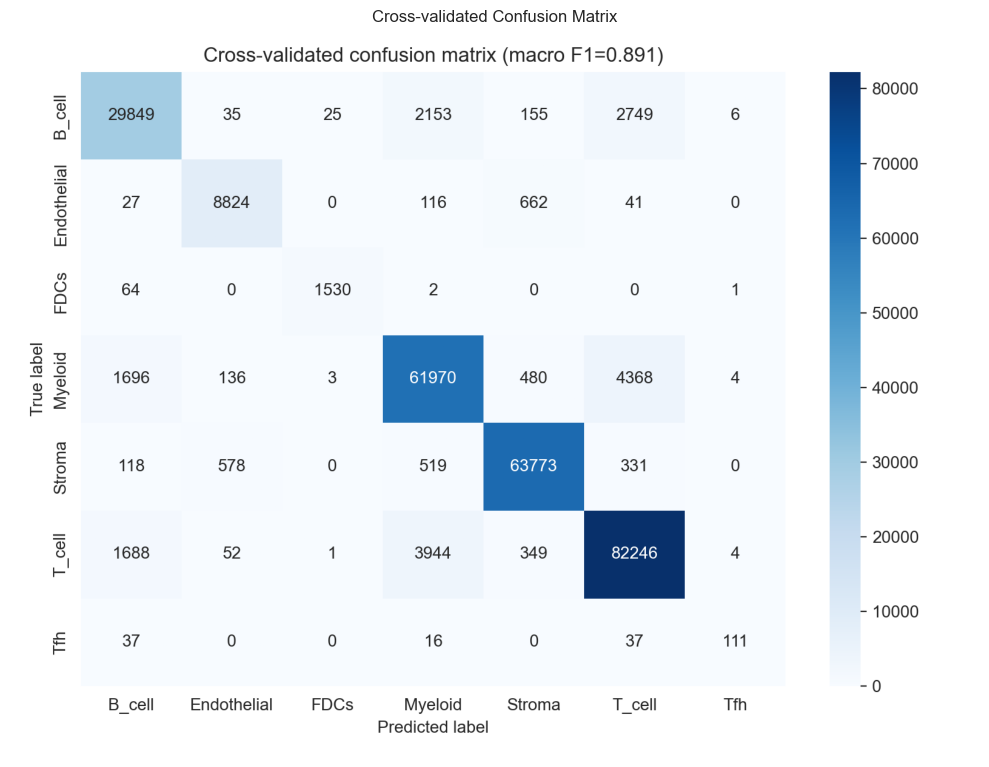

Confusion matrix displayed


In [37]:
# Display confusion matrix plot
from matplotlib.image import imread

cm_path = qc_dir / 'cv_confusion_matrix.png'
if cm_path.exists():
    fig, ax = plt.subplots(figsize=(10, 8))
    img = imread(cm_path)
    ax.imshow(img)
    ax.axis('off')
    plt.title('Cross-validated Confusion Matrix')
    plt.tight_layout()
    plt.show()
    print('Confusion matrix displayed')

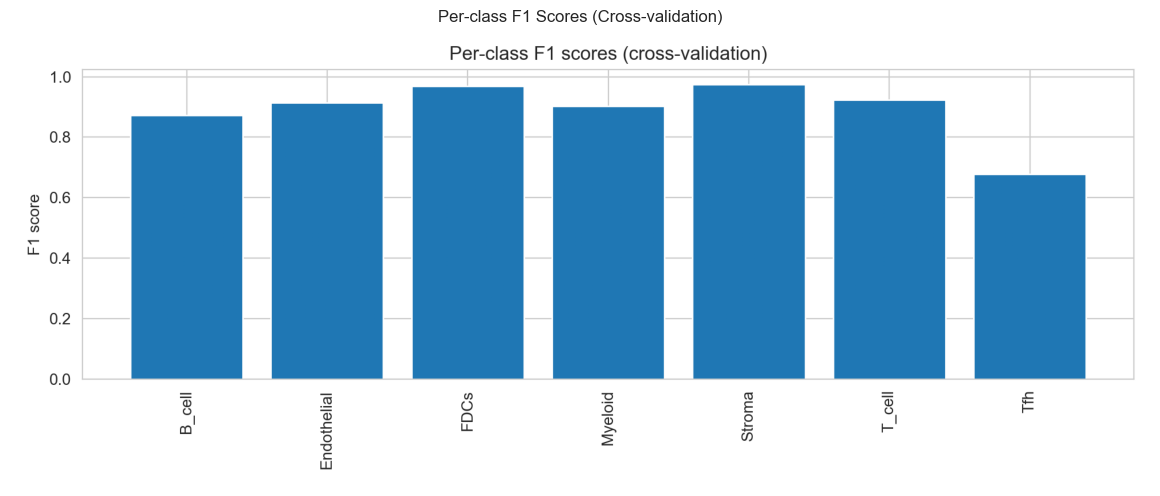

Per-class F1 plot displayed


In [38]:
# Display per-class F1 scores
f1_path = qc_dir / 'cv_per_class_f1.png'
if f1_path.exists():
    fig, ax = plt.subplots(figsize=(12, 5))
    img = imread(f1_path)
    ax.imshow(img)
    ax.axis('off')
    plt.title('Per-class F1 Scores (Cross-validation)')
    plt.tight_layout()
    plt.show()
    print('Per-class F1 plot displayed')

## 8. Make Predictions on Target Timepoint

In [39]:
# Extract features for target timepoint
print(f'Extracting features for target timepoint {TARGET_TIMEPOINT}...')

X_target, _ = extract_x_target(
    adata_target,
    use_layer=LAYER,
    use_obsm_key=OBSM_KEY,
    selected_feature_indices=selected_feature_indices,
)

print(f'✓ Target features extracted')
print(f'  Shape: {X_target.shape}')
print(f'  Number of cells: {X_target.shape[0]}')

Extracting features for target timepoint [3.0, 4.0, 5.0]...
✓ Target features extracted
  Shape: (594371, 47)
  Number of cells: 594371


/home/md-adnan-karim/Documents/git_repo/cytofLabelTransfer/cytofPredictionModel/cytof_label_transfer/data_utils.py:94: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if obsm_key not in adata.obsm_keys():


In [40]:
# Make predictions
print(f'Making predictions on {adata_target.n_obs} cells...')

y_pred, y_proba = predict_timepoint(bundle, X_target)

print(f'✓ Predictions completed')
print(f'  Number of predictions: {len(y_pred)}')
print(f'  Predicted classes: {np.unique(y_pred)}')
print(f'\nPrediction distribution:')
print(pd.Series(y_pred).value_counts().sort_index())

Making predictions on 594371 cells...
✓ Predictions completed
  Number of predictions: 594371
  Predicted classes: ['B_cell' 'Endothelial' 'FDCs' 'Myeloid' 'Stroma' 'T_cell' 'Tfh']

Prediction distribution:
B_cell         101112
Endothelial     18310
FDCs             4485
Myeloid        115096
Stroma         113774
T_cell         241039
Tfh               555
Name: count, dtype: int64



Prediction Confidence Statistics:
  Mean: 0.9467
  Median: 0.9990
  Min: 0.2682
  Max: 1.0000
  Std: 0.1140


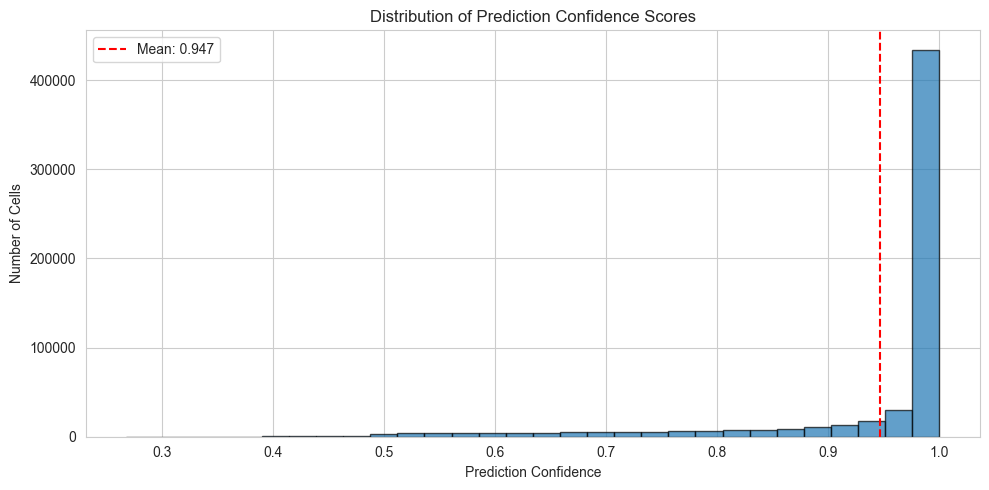

In [41]:
# Extract prediction confidence (max probability)
if y_proba is not None:
    max_confidence = y_proba.max(axis=1)
    print(f'\nPrediction Confidence Statistics:')
    print(f'  Mean: {max_confidence.mean():.4f}')
    print(f'  Median: {np.median(max_confidence):.4f}')
    print(f'  Min: {max_confidence.min():.4f}')
    print(f'  Max: {max_confidence.max():.4f}')
    print(f'  Std: {max_confidence.std():.4f}')
    
    # Visualize confidence distribution
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(max_confidence, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(max_confidence.mean(), color='red', linestyle='--', label=f'Mean: {max_confidence.mean():.3f}')
    ax.set_xlabel('Prediction Confidence')
    ax.set_ylabel('Number of Cells')
    ax.set_title('Distribution of Prediction Confidence Scores')
    ax.legend()
    plt.tight_layout()
    plt.show()

## 9. Write Predictions Back to AnnData

In [42]:
# Add predictions to the full AnnData object
print(f'Writing predictions to AnnData object...')

# Initialize columns
adata.obs['Clust_all_260130'] = pd.Series(index=adata.obs_names, dtype='object')
adata.obs['prediction_confidence_260130'] = pd.Series(index=adata.obs_names, dtype='float')

# Fill in predictions for target cells
adata.obs.loc[adata_target.obs_names, 'Clust_all_260130'] = y_pred

if y_proba is not None:
    adata.obs.loc[adata_target.obs_names, 'prediction_confidence_260130'] = max_confidence

print(f'✓ Predictions added to adata.obs')
print(f'\nColumns in adata.obs:')
print(adata.obs[['Clust_all_260130', 'prediction_confidence_260130']].head(10))

Writing predictions to AnnData object...
✓ Predictions added to adata.obs

Columns in adata.obs:
                                                Clust_all_260130  \
1_20_15401_Healthy_lymphonode_11.11.2025_001_4           Myeloid   
1_20_15401_Healthy_lymphonode_11.11.2025_001_5           Myeloid   
1_20_15401_Healthy_lymphonode_11.11.2025_001_6            T_cell   
1_20_15401_Healthy_lymphonode_11.11.2025_001_7            T_cell   
1_20_15401_Healthy_lymphonode_11.11.2025_001_8            T_cell   
1_20_15401_Healthy_lymphonode_11.11.2025_001_9            T_cell   
1_20_15401_Healthy_lymphonode_11.11.2025_001_10           T_cell   
1_20_15401_Healthy_lymphonode_11.11.2025_001_12           T_cell   
1_20_15401_Healthy_lymphonode_11.11.2025_001_13           T_cell   
1_20_15401_Healthy_lymphonode_11.11.2025_001_14           B_cell   

                                                 prediction_confidence_260130  
1_20_15401_Healthy_lymphonode_11.11.2025_001_4                       0.997

In [43]:
# Save updated AnnData
output_h5ad = OUTPUT_DIR / 'data_with_predictions.h5ad'

print(f'Saving updated AnnData to {output_h5ad}...')
adata.write_h5ad(output_h5ad)

print(f'✓ Saved successfully')
print(f'  File size: {output_h5ad.stat().st_size / 1024 / 1024:.1f} MB')

Saving updated AnnData to results/data_with_predictions.h5ad...
✓ Saved successfully
  File size: 2080.8 MB


## 10. Visualize Results

In [44]:
# Comparison of original vs predicted labels (for target timepoint)
if LABEL_COL in adata_target.obs.columns:
    original_labels = adata_target.obs[LABEL_COL]
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'original': original_labels,
        'predicted': y_pred,
        'confidence': max_confidence if y_proba is not None else 1.0,
    })
    
    print('Sample Predictions vs Original Labels:')
    print(comparison_df.head(20).to_string())
    
    # Count matches
    matches = (original_labels == y_pred).sum()
    total = len(y_pred)
    accuracy = matches / total
    print(f'\nComparison with original labels:')
    print(f'  Matches: {matches}/{total} ({accuracy*100:.1f}%)')
else:
    print('Note: No original labels for target timepoint to compare')

Sample Predictions vs Original Labels:
                                                    original predicted  confidence
1_20_15401_Healthy_lymphonode_11.11.2025_001_4   Endothelial   Myeloid    0.997992
1_20_15401_Healthy_lymphonode_11.11.2025_001_5       Myeloid   Myeloid    0.991740
1_20_15401_Healthy_lymphonode_11.11.2025_001_6        T_cell    T_cell    0.999984
1_20_15401_Healthy_lymphonode_11.11.2025_001_7        Stroma    T_cell    0.999956
1_20_15401_Healthy_lymphonode_11.11.2025_001_8        Stroma    T_cell    0.849201
1_20_15401_Healthy_lymphonode_11.11.2025_001_9        T_cell    T_cell    0.999589
1_20_15401_Healthy_lymphonode_11.11.2025_001_10       Stroma    T_cell    0.999477
1_20_15401_Healthy_lymphonode_11.11.2025_001_12       T_cell    T_cell    0.997920
1_20_15401_Healthy_lymphonode_11.11.2025_001_13       T_cell    T_cell    0.992075
1_20_15401_Healthy_lymphonode_11.11.2025_001_14       B_cell    B_cell    0.997787
1_20_15401_Healthy_lymphonode_11.11.2025_001_15 

In [45]:
# Summary statistics
print('\n' + '='*60)
print('WORKFLOW SUMMARY')
print('='*60)
print(f'\nInput Data:')
print(f'  Total cells: {adata.n_obs}')
print(f'  Training set: {adata_train.n_obs} cells')
print(f'  Target set: {adata_target.n_obs} cells')
print(f'\nFeatures:')
print(f'  Initial features: {len(feature_names) + (len(selected_feature_indices) if selected_feature_indices is not None else 0)}')
print(f'  Features used: {len(feature_names)}')
print(f'\nModel:')
print(f'  Algorithm: XGBoost')
print(f'  Classes: {len(bundle.label_names)}')
print(f'  CV F1 Score: {bundle.cv_best_score:.4f}')
print(f'\nPredictions:')
print(f'  Predictions made: {len(y_pred)}')
if y_proba is not None:
    print(f'  Mean confidence: {max_confidence.mean():.4f}')
print(f'\nOutput Files:')
print(f'  Model: {MODEL_DIR}')
print(f'  QC plots: {MODEL_DIR / "qc"}')
print(f'  Predictions: {output_h5ad}')
print('='*60)


WORKFLOW SUMMARY

Input Data:
  Total cells: 863071
  Training set: 268700 cells
  Target set: 594371 cells

Features:
  Initial features: 47
  Features used: 47

Model:
  Algorithm: XGBoost
  Classes: 7
  CV F1 Score: 0.8908

Predictions:
  Predictions made: 594371
  Mean confidence: 0.9467

Output Files:
  Model: results/trained_model
  QC plots: results/trained_model/qc
  Predictions: results/data_with_predictions.h5ad


## Next Steps

1. **Review the QC plots** in the `qc/` directory to assess model quality
2. **Check the predictions** and their confidence scores
3. **Validate results** by comparing with original labels if available
4. **Adjust parameters** if needed:
   - Try different feature selections
   - Experiment with custom hyperparameters
   - Increase/decrease CV iterations
5. **Use the trained model** to predict on new data

For more information, see:
- [ADVANCED_USAGE.md](ADVANCED_USAGE.md) for detailed feature documentation
- [PRACTICAL_EXAMPLES.md](PRACTICAL_EXAMPLES.md) for more code examples
- [README.md](README.md) for installation and basic usage

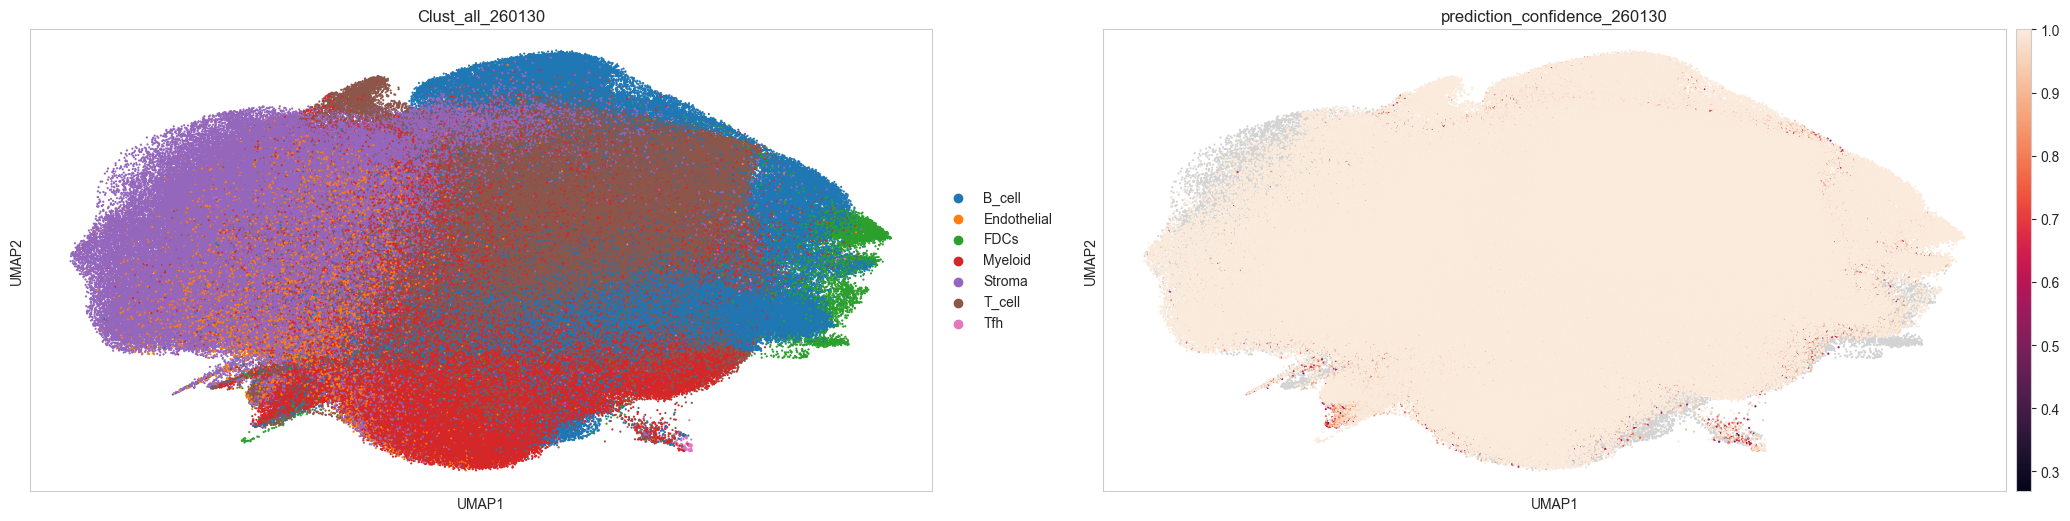

In [50]:
sc.pl.umap(adata, color=['Clust_all_260130', 'prediction_confidence_260130'], size=10)

In [47]:
adata.obs["Clust_all_260130"].value_counts()

Clust_all_260130
T_cell         241039
Myeloid        115096
Stroma         113774
B_cell         101112
Endothelial     18310
FDCs             4485
Tfh               555
Name: count, dtype: int64

In [49]:
clust_all_1_2 = adata.obs[adata.obs["ROI_round_id"].isin([1.0,2.0])].copy()
# Match indices and update the values in 'celltype_predicted'
adata.obs['Clust_all_260130'].update(clust_all_1_2['Gate_immune'])
del clust_all_1_2

/tmp/ipykernel_44747/130521268.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['Clust_all_260130'].update(clust_all_1_2['Gate_immune'])


/tmp/ipykernel_44747/2670594816.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_props = (df_bcells.groupby(["ROI_round_id", "timepoint", "sample_id"])["Clust_all_260130"]
/tmp/ipykernel_44747/2670594816.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_props = (sample_props.groupby(["ROI_round_id", "timepoint", "Clust_all_260130"])["proportion"]


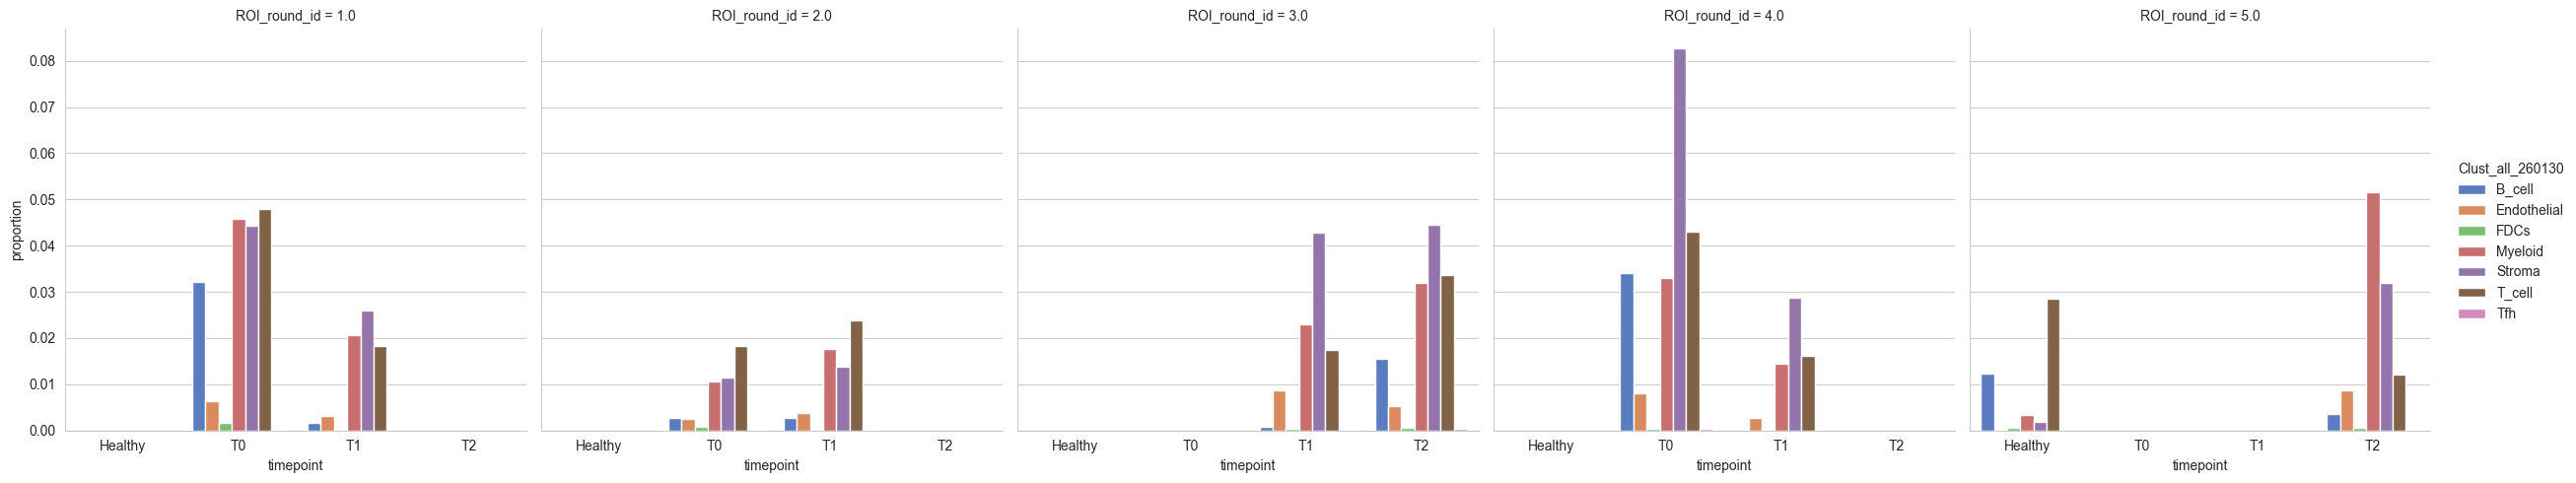

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Explicitly define the B-cell subtypes you want to keep
b_cell_types = [
    "T_cell",         
"Myeloid",        
"Stroma",         
"B_cell",         
"Endothelial",     
"FDCs",             
"Tfh"               
]

# 2. Filter the data first
# We use .copy() to avoid SettingWithCopy warnings
mask = (adata.obs["Clust_all_260130"].isin(b_cell_types)) & \
       (adata.obs["ROI_round_id"].isin([1.0, 2.0, 3.0,4.0,5.0]))
df_bcells = adata.obs[mask].copy()

# 1. Group by Sample AND Celltype to get proportions for each individual specimen
# Replace 'sample_id' with your actual column name for individual samples
sample_props = (df_bcells.groupby(["ROI_round_id", "timepoint", "sample_id"])["Clust_all_260130"]
                .value_counts(normalize=True)
                .reset_index(name="proportion"))

# 2. Now average those proportions across samples within the same timepoint/ROI
final_props = (sample_props.groupby(["ROI_round_id", "timepoint", "Clust_all_260130"])["proportion"]
               .mean()
               .reset_index())

# 3. Plot (Now representing the average composition per sample)
g = sns.catplot(
    data=final_props,
    kind="bar",
    x="timepoint", 
    y="proportion",
    hue="Clust_all_260130",
    col="ROI_round_id",
    palette="muted",
    height=5, 
    aspect=1
)

# Optional: Add error bars by using the 'sample_props' dataframe directly in sns.barplot
# Seaborn will automatically calculate the mean and 95% CI
# g = sns.catplot(data=sample_props, x="timepoint", y="proportion", hue="celltype_predicted_1_2"...)

In [54]:
df_export = adata.obs.copy()
df_export['UMAP_1'] = adata.obsm['X_umap'][:, 0]
df_export['UMAP_2'] = adata.obsm['X_umap'][:, 1]
        
        # Sanitize filename (remove spaces or slashes if category name has them)
safe_name = str("gate_immune_prediction").replace("/", "_").replace(" ", "_")
df_export.to_csv(f'{"/home/md-adnan-karim/Documents/git_repo/cytofLabelTransfer/cytofPredictionModel/metadata_umap"}/{safe_name}_metadata_with_umap.csv', index_label='cell_barcode')